<a href="https://colab.research.google.com/github/kaitlyn-wong/MaritimeImageEnhancement/blob/master/autoencoder_3_RGB_noisefactor2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# src = https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import os 
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import pandas as pd 
from google.colab import drive 
drive.mount('/content/drive/')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
myDir = "/content/drive/MyDrive/maritime_dataset/maritime_processed_images240/"

# getting dataset from bwfolder and defining it as clean_img_list 

clean_img_list = []

for pic in os.listdir(myDir):

  bwimg = cv2.imread(os.path.join(myDir, pic), cv2.IMREAD_ANYCOLOR)

  bwimg = cv2.cvtColor(bwimg, cv2.COLOR_BGR2RGB)

  clean_img_list.append(bwimg)

## changing the clean_img_list from 2D array to 3D array 

clean_img_np = np.array(clean_img_list)

print(clean_img_np.shape)

# adding noise to the images

noise_factor = 2.0

# formula to randomly alter every pixel value in the image

# np.random.normal() generate a normal distribution of random number from 0 to 255 

noisy_img_np = clean_img_np + noise_factor * np.random.normal(loc=0.0, scale=125.0, size=clean_img_np.shape)

# any number lower than lower bound will be given lower bound value (automatically clip back to 255 no matter what the value is)

noisy_img_np = np.clip(noisy_img_np, 0., 255.)

print(noisy_img_np.shape)

# normalise image 

# each pixel in image is coded by a number (base on colour intensity, darker the color lower the number)

# previously pixel value range from 0 to 255, using this method the value will range from 0 to 1

noisy_img_np = np.true_divide(noisy_img_np, 255.)

clean_img_np = np.true_divide(clean_img_np, 255.)

(50, 240, 240, 3)
(50, 240, 240, 3)


In [ ]:
## splitting into train and test 

x_train, x_test, y_train, y_test = train_test_split(noisy_img_np, clean_img_np, 
                                                  train_size=0.5,
                                                  test_size=0.5,
                                                  random_state=122)

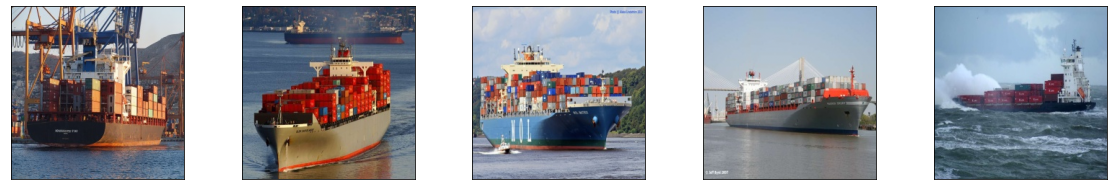

In [ ]:
# display the input of the image before adding noise
n = 5

plt.figure(figsize=(20, 7))

for i in range(n):

     # display original

     ax = plt.subplot(2, n, i + 1)

     plt.imshow(clean_img_np[i].reshape(240, 240, 3))
 
     ax.get_xaxis().set_visible(False)

     ax.get_yaxis().set_visible(False)

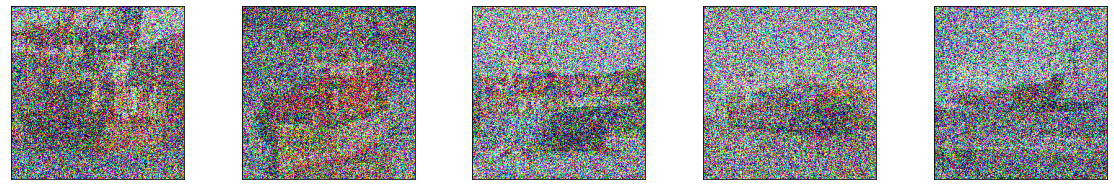

In [ ]:
# display the input of the image after adding noise

n = 5

plt.figure(figsize=(20, 7))

for i in range(n):

     # display original

     ax = plt.subplot(2, n, i + 1)

     plt.imshow(noisy_img_np[i].reshape(240, 240, 3))
 
     ax.get_xaxis().set_visible(False)

     ax.get_yaxis().set_visible(False)

In [ ]:
# Change matrix dimension 

# matrix.reshape(no. of images, width, height, channels)

# if bw, channel = 1

# if colour, channel = 3 (normally)

x_train = x_train.astype('float32') 

x_test = x_test.astype('float32') 

# dataframe.astype() to case column data type to another data type

In [ ]:
input_layer = Input(shape=(240,240, 3))
        
# encoder

encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(input_layer)

encoder = MaxPooling2D((2, 2), padding='same')(encoder)

# decoder

decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)

decoder = UpSampling2D((2, 2))(decoder)

output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder)

autoencoder = Model(input_layer, output_layer)

autoencoder.compile(loss='mse', optimizer=Adam(lr=0.001))

batch_size = 16

epochs = 50

early_stopping = EarlyStopping(monitor='loss',min_delta=0,patience=5,verbose=1, mode='auto')

In [ ]:
# summary of model layers build 

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 240, 240, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 120, 256)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 256)     590080    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 240, 240, 256)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 240, 240, 3)       6915      
Total params: 604,163
Trainable params: 604,163
Non-trainable params: 0
_____________________________________________________

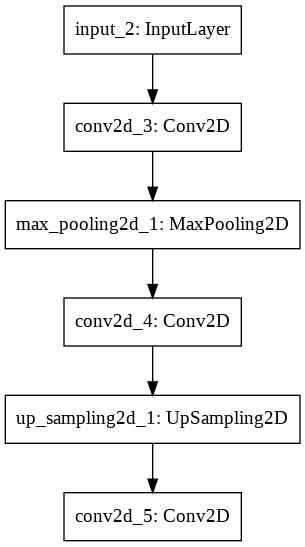

In [ ]:
# display model layer in diagram 

plot_model(autoencoder)

In [ ]:
# training the model with clean images 

history = autoencoder.fit(y_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])

Epoch 1/50
2/2 [==============================] - 44s 15s/step - loss: 0.0660
Epoch 2/50
2/2 [==============================] - 43s 15s/step - loss: 0.0463
Epoch 3/50
2/2 [==============================] - 42s 15s/step - loss: 0.0406
Epoch 4/50
2/2 [==============================] - 42s 15s/step - loss: 0.0448
Epoch 5/50
2/2 [==============================] - 42s 15s/step - loss: 0.0369
Epoch 6/50
2/2 [==============================] - 42s 15s/step - loss: 0.0370
Epoch 7/50
2/2 [==============================] - 43s 15s/step - loss: 0.0296
Epoch 8/50
2/2 [==============================] - 43s 15s/step - loss: 0.0243
Epoch 9/50
2/2 [==============================] - 42s 15s/step - loss: 0.0200
Epoch 10/50
2/2 [==============================] - 42s 15s/step - loss: 0.0140
Epoch 11/50
2/2 [==============================] - 42s 15s/step - loss: 0.0108
Epoch 12/50
2/2 [==============================] - 43s 15s/step - loss: 0.0075
Epoch 13/50
2/2 [==============================] - 43s 15s/st

In [ ]:
# test the trained model on the test data set

decoded_imgs = autoencoder.predict(y_test)

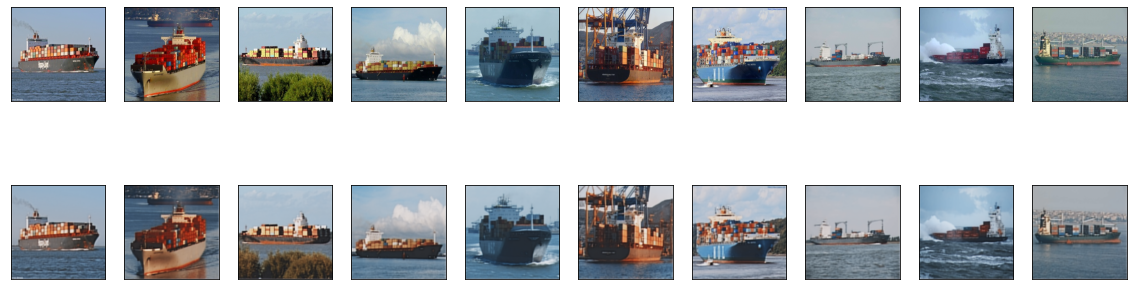

In [ ]:
# Display image of input and output of autoencoder model 
n = 10

# change back to y_test later 

plt.figure(figsize=(20, 6))

for i in range(n):

    # display original

     ax = plt.subplot(2, n, i + 1)

     plt.imshow(y_test[i].reshape(240, 240, 3))
 
     ax.get_xaxis().set_visible(False)

     ax.get_yaxis().set_visible(False)

    # display reconstruction

     ax = plt.subplot(2, n, i+1+n)

     plt.imshow(decoded_imgs[i].reshape(240, 240, 3))

     ax.get_xaxis().set_visible(False)

     ax.get_yaxis().set_visible(False)
     
plt.show()

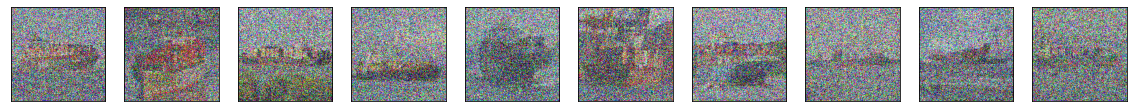

In [ ]:
# display the input of the image after adding noise

n = 10

plt.figure(figsize=(20, 3))

for i in range(n):

     ax = plt.subplot(1, n, i+1)

     plt.imshow(x_test[i].reshape(240, 240, 3))

     plt.gray()

     ax.get_xaxis().set_visible(False)

     ax.get_yaxis().set_visible(False)
     
plt.show()

In [29]:
# train the model with the noisy image

autoencoder.fit(x_train, x_train, # changed second to from y_train 
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(y_test, y_test) # changed first from x_test
               )

Epoch 1/50
1/1 [==============================] - 53s 53s/step - loss: 0.2467 - val_loss: 0.0997
Epoch 2/50
1/1 [==============================] - 53s 53s/step - loss: 0.3006 - val_loss: 0.1180
Epoch 3/50
1/1 [==============================] - 53s 53s/step - loss: 0.3340 - val_loss: 0.0848
Epoch 4/50
1/1 [==============================] - 53s 53s/step - loss: 0.2662 - val_loss: 0.0096
Epoch 5/50
1/1 [==============================] - 52s 52s/step - loss: 0.1933 - val_loss: 0.0041
Epoch 6/50
1/1 [==============================] - 54s 54s/step - loss: 0.2568 - val_loss: 0.0183
Epoch 7/50
1/1 [==============================] - 53s 53s/step - loss: 0.1717 - val_loss: 0.0649
Epoch 8/50
1/1 [==============================] - 52s 52s/step - loss: 0.2130 - val_loss: 0.0704
Epoch 9/50
1/1 [==============================] - 53s 53s/step - loss: 0.2252 - val_loss: 0.0425
Epoch 10/50
1/1 [==============================] - 53s 53s/step - loss: 0.1767 - val_loss: 0.0124
Epoch 11/50
1/1 [============

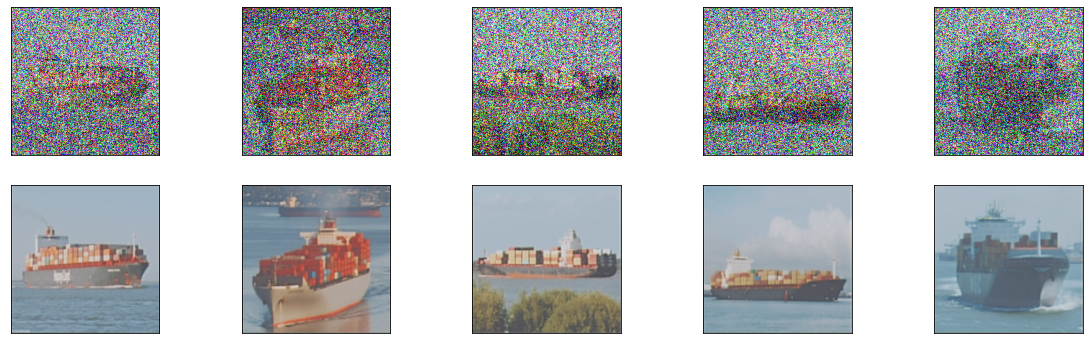

In [30]:
# test trained model on test images

decoded_imgs = autoencoder.predict(y_test)

n = 5


# display of input and output of autoencoder model 

plt.figure(figsize=(20, 6))

for i in range(n):

    # display original

    ax = plt.subplot(2, n, i + 1)

    plt.imshow(x_test[i].reshape(240, 240, 3))

    ax.get_xaxis().set_visible(False)  

    ax.get_yaxis().set_visible(False)

    # display reconstruction

    ax = plt.subplot(2, n, i+1+n)

    plt.imshow(decoded_imgs[i].reshape(240, 240, 3))

    plt.gray()

    ax.get_xaxis().set_visible(False)

    ax.get_yaxis().set_visible(False)
    
plt.show()